<a href="https://colab.research.google.com/github/Danangellotti/Ciencia_de_Datos_UGR_24/blob/main/TP1_ProduccionImagenes_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Objetivo:
# Detectar y clasificar formas geométricas básicas (círculos, cuadrados, triángulos, rectángulos) en imágenes utilizando OpenCV.
# Descripción:
# Deberán utilizar técnicas de procesamiento de imágenes para identificar formas geométricas.
# Pueden presentar el mismo en grupos de hasta 3 alumnos. Deberan  aplicar operaciones de umbralización, detección de bordes y contornos para identificar y clasificar formas.




Procesando imagen 1...

Procesando imagen 2...

Procesando imagen 3...

Procesando imagen 4...


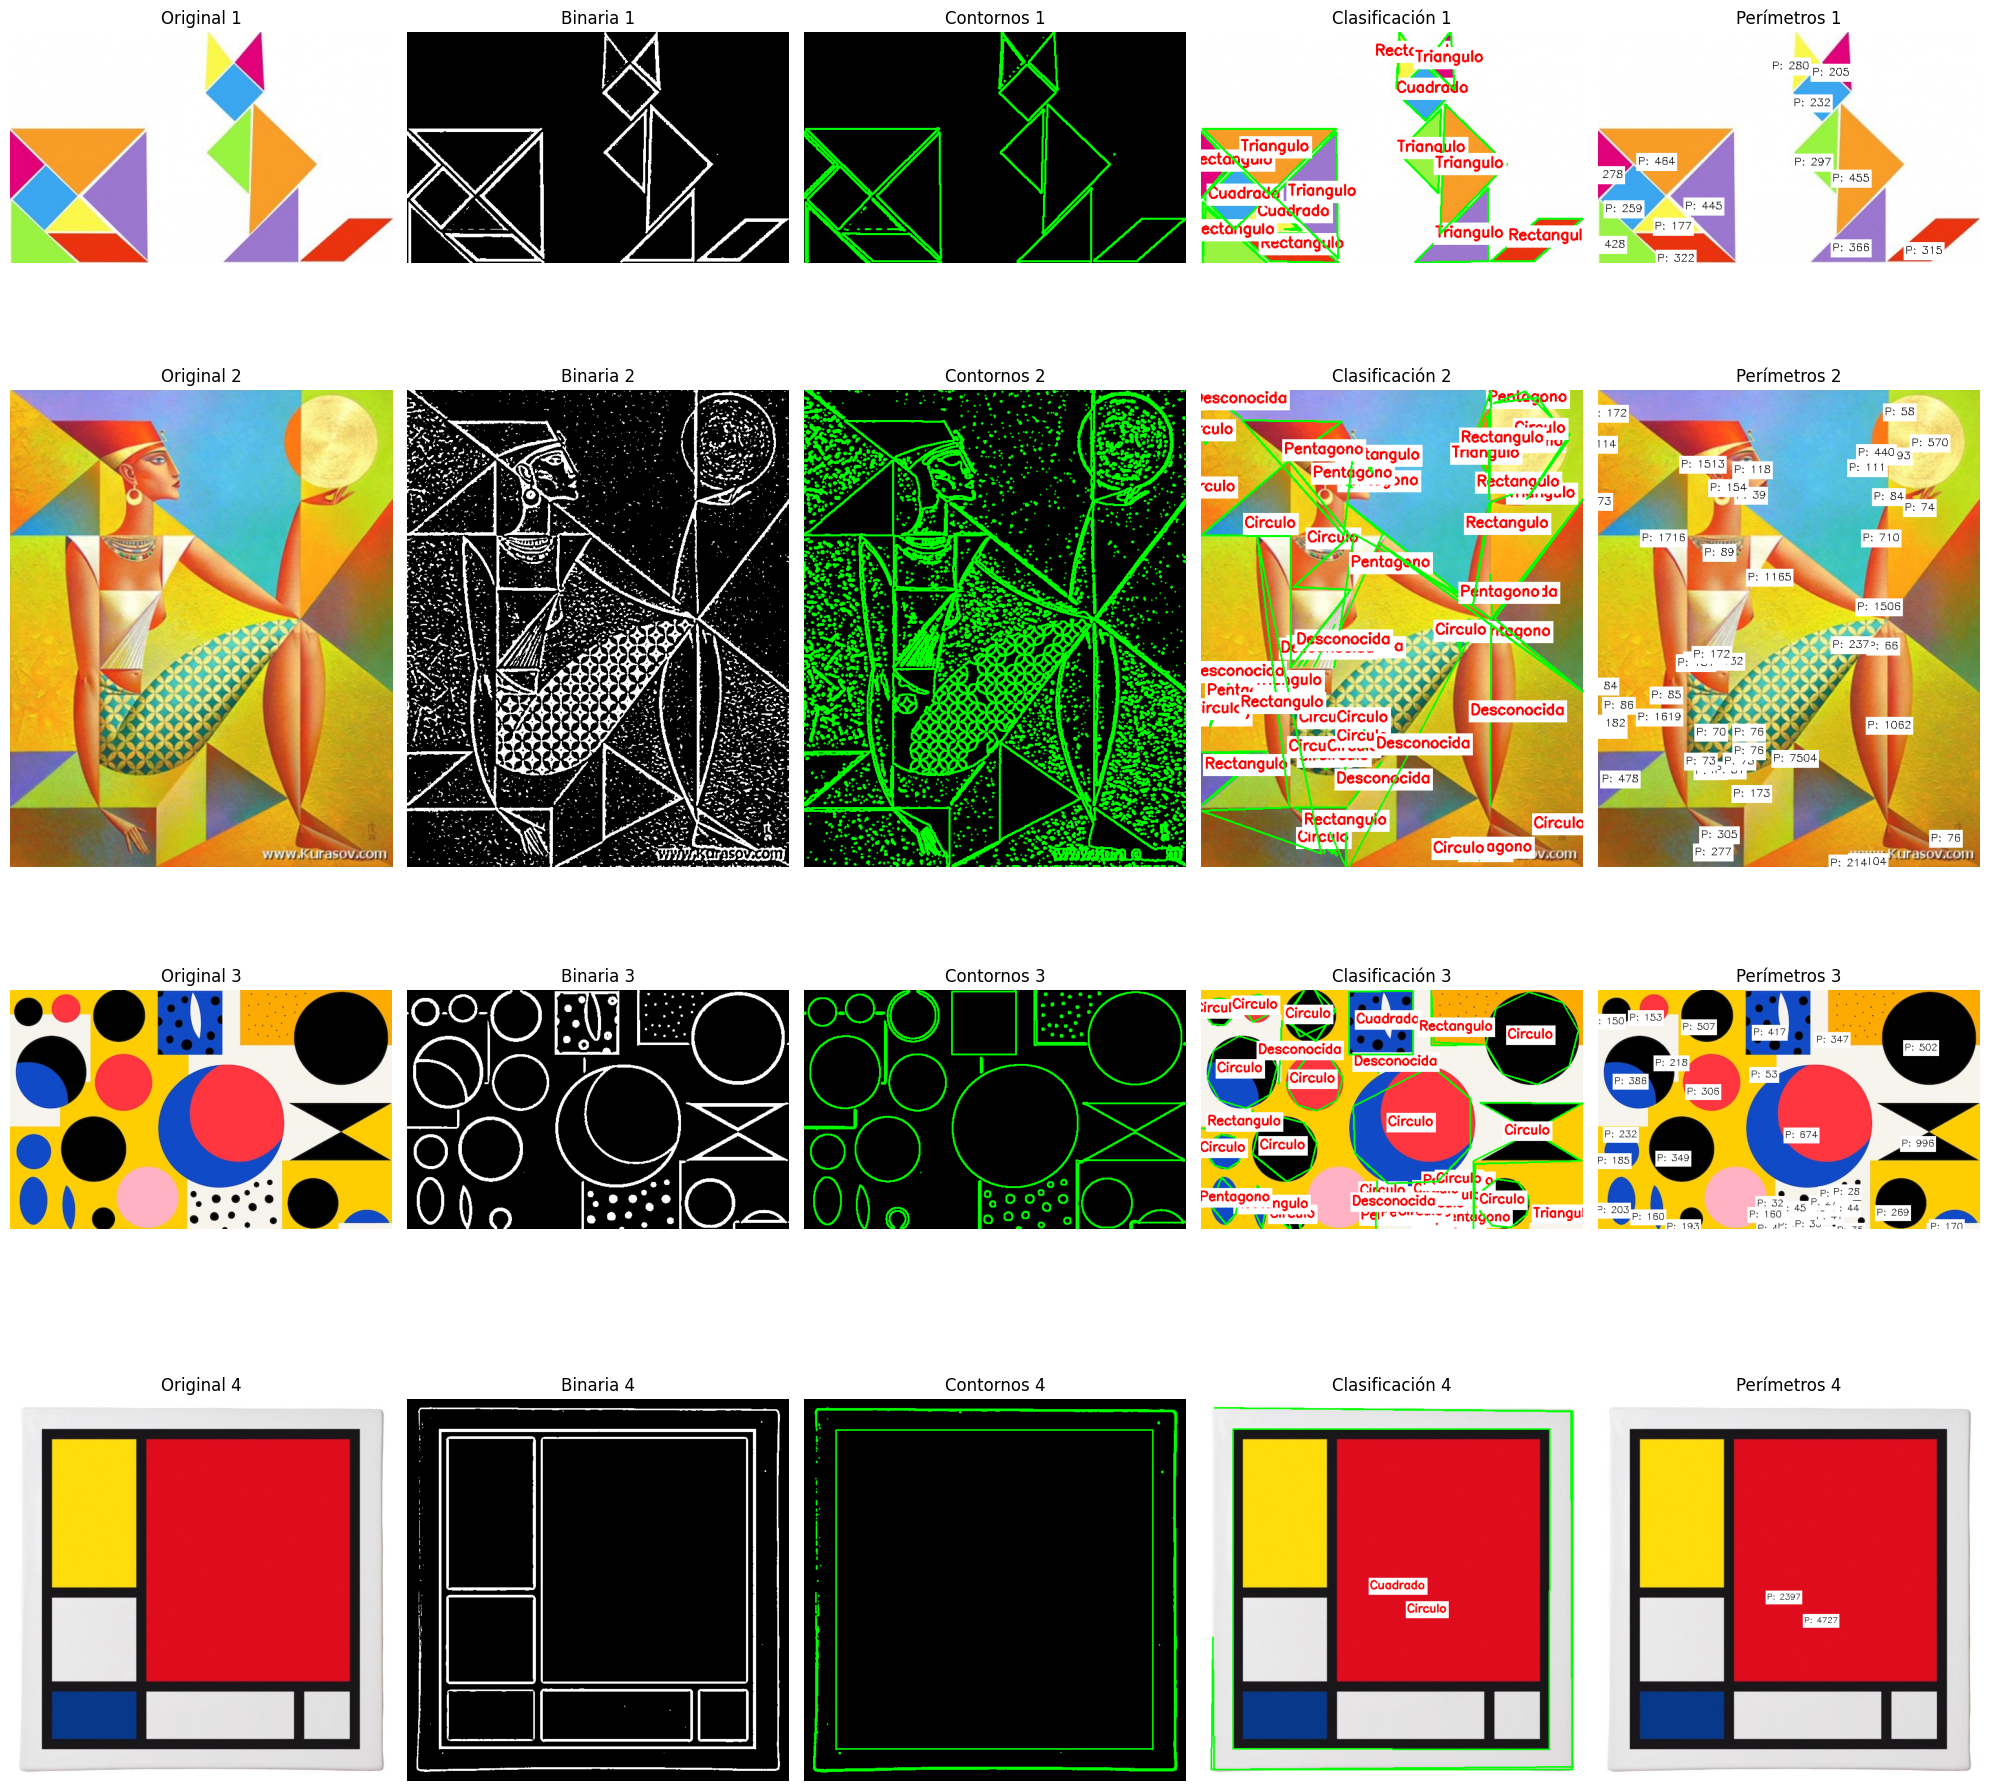

In [ ]:
import requests
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Lista de URLs con imágenes que contienen figuras geométricas
# El objetivo es detectar las figuras, clasificarlas y mostrar su perímetro.
urls = [

   "https://i.pinimg.com/564x/12/81/7d/12817d843e6f71ac3fbbeafd711593ef.jpg",
   "https://i.pinimg.com/564x/1b/c8/06/1bc806be7192818e1aef2c0067d809d2.jpg",
   "https://img.freepik.com/vector-premium/obras-arte-coloridas-figuras-geometricas-elementos-graficos-audaces-composicion-plana_167718-1130.jpg",
    "https://www.rionegro.com.ar/wp-content/uploads/2024/01/cuadros-mondrian-arte-abstracto-20x20-decoracion-mondrian-11934-mla20052593222_022014-f.jpg?w=720"
]

# Crear un grid de subplots para mostrar 5 resultados por imagen
# Columnas: [original, binaria, contornos, clasificación, perímetros]
num_images = len(urls)
fig, axs = plt.subplots(num_images, 5, figsize=(20, 5 * num_images))

# Procesar cada imagen
for i, url in enumerate(urls):
    print(f"\nProcesando imagen {i+1}...")

    # -----------------------------
    # DESCARGA Y DECODIFICACIÓN
    # -----------------------------
    try:
        img = requests.get(url)
        img.raise_for_status()  # Lanza excepción si hubo un error HTTP
        imagen = np.frombuffer(img.content, np.uint8)
        imagen_color = cv2.imdecode(imagen, cv2.IMREAD_COLOR)  # Convertir a arreglo BGR
    except requests.exceptions.RequestException as e:
        print(f"Error al descargar o procesar la imagen desde: {url}, Error: {e}")
        # Mostrar subplots vacíos en caso de error
        axs[i, 0].imshow(np.zeros((100, 100, 3), dtype=np.uint8))
        axs[i, 0].set_title(f'Error: {i+1}')
        for j in range(1, 5):
            axs[i, j].imshow(np.zeros((100, 100), dtype=np.uint8), cmap='gray')
            axs[i, j].axis('off')
        continue

    # --------------------------------
    # PREPROCESAMIENTO DE LA IMAGEN
    # --------------------------------
    imagen_gris = cv2.cvtColor(imagen_color, cv2.COLOR_BGR2GRAY)  # Convertir a escala de grises
    imagen_suave = cv2.GaussianBlur(imagen_gris, (5, 5), 0)       # Reducir el ruido con suavizado

    # Aplicamos umbral adaptativo para convertir a binario
    # Esto es mejor que un umbral fijo cuando hay variaciones de iluminación
    imagen_binaria = cv2.adaptiveThreshold(
        imagen_suave, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # Promedia píxeles locales ponderados
        cv2.THRESH_BINARY_INV,           # Invierte: figuras blancas sobre fondo negro
        11, 2                            # Bloque de 11x11 y constante 2 para ajustar el umbral
    )

    # --------------------------
    # DETECCIÓN DE CONTORNOS
    # --------------------------
    # Los contornos se obtienen sobre la imagen binaria. Solo se consideran contornos externos.
    contornos, _ = cv2.findContours(imagen_binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    imagen_contornos = np.zeros_like(imagen_color)
    cv2.drawContours(imagen_contornos, contornos, -1, (0, 255, 0), 2)

    # ----------------------------------
    # CLASIFICACIÓN DE FIGURAS GEOMÉTRICAS
    # ----------------------------------
    imagen_resultado = imagen_color.copy()
    for contorno in contornos:
        area = cv2.contourArea(contorno)
        if area > 50:  # Descartar contornos pequeños o ruido
            perimetro = cv2.arcLength(contorno, True)
            aprox = cv2.approxPolyDP(contorno, 0.04 * perimetro, True)  # Aproximar forma poligonal
            vertices = len(aprox)

            # Clasificar figura por número de lados (vértices)
            if vertices == 3:
                forma = "Triangulo"
            elif vertices == 4:
                x, y, w, h = cv2.boundingRect(aprox)
                aspect_ratio = w / float(h)
                forma = "Cuadrado" if 0.95 <= aspect_ratio <= 1.05 else "Rectangulo"
            elif vertices == 5:
                forma = "Pentagono"
            elif vertices > 5:
                forma = "Circulo"
            else:
                forma = "Desconocida"


            # Obtener centro del contorno para posicionar etiquetas
            M = cv2.moments(contorno)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                cv2.drawContours(imagen_resultado, [aprox], -1, (0, 255, 0), 2)

                # Dibujar rectángulo blanco como fondo del texto
                (text_width, text_height), baseline = cv2.getTextSize(forma, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
                cv2.rectangle(imagen_resultado,
                              (cX - 42, cY - text_height - 4),
                              (cX - 42 + text_width + 4, cY + baseline + 4),
                              (255, 255, 255), -1)

                # Escribir el nombre de la figura en rojo
                cv2.putText(imagen_resultado, forma, (cX - 40, cY),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    # ----------------------------------
    # CÁLCULO Y ETIQUETADO DE PERÍMETROS
    # ----------------------------------
    imagen_perimetros = imagen_color.copy()
    for contorno in contornos:
        area = cv2.contourArea(contorno)
        if area > 50:
            perimetro = cv2.arcLength(contorno, True)
            M = cv2.moments(contorno)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                texto = f"P: {int(perimetro)}"  # Etiqueta con valor entero del perímetro

                # Dibujar fondo blanco detrás del texto
                (text_width, text_height), baseline = cv2.getTextSize(texto, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
                cv2.rectangle(imagen_perimetros,
                              (cX - 42, cY + 20 - text_height - 4),
                              (cX - 42 + text_width + 4, cY + 20 + baseline + 4),
                              (255, 255, 255), -1)

                # Escribir el perímetro en color negro para buena legibilidad
                cv2.putText(imagen_perimetros, texto, (cX - 40, cY + 20),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

    # ---------------------
    # VISUALIZACIÓN FINAL
    # ---------------------
    axs[i, 0].imshow(cv2.cvtColor(imagen_color, cv2.COLOR_BGR2RGB))
    axs[i, 0].set_title(f'Original {i+1}')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(imagen_binaria, cmap='gray')
    axs[i, 1].set_title(f'Binaria {i+1}')
    axs[i, 1].axis('off')

    axs[i, 2].imshow(cv2.cvtColor(imagen_contornos, cv2.COLOR_BGR2RGB))
    axs[i, 2].set_title(f'Contornos {i+1}')
    axs[i, 2].axis('off')

    axs[i, 3].imshow(cv2.cvtColor(imagen_resultado, cv2.COLOR_BGR2RGB))
    axs[i, 3].set_title(f'Clasificación {i+1}')
    axs[i, 3].axis('off')

    axs[i, 4].imshow(cv2.cvtColor(imagen_perimetros, cv2.COLOR_BGR2RGB))
    axs[i, 4].set_title(f'Perímetros {i+1}')
    axs[i, 4].axis('off')

# Ajusta los espacios entre subplots para mejor visualización
plt.tight_layout()
plt.show()

In [ ]:
#Observando que se superpone mucho la visualización de las impagenes y la detección de círculos y rectángulos: procedemos a hacer mejoras en el código
#Separamos por tipo de figura para que sea más sencillo visualizarlo en imágenes complejas,
#se mejora la detección de contornos para que incluya también contornos internos
#y se mejora la detección de círculos y paralelogramos, ya que clasificaba a cualquier paralelogramo como rectángulo
#se evita la visualización de imágenes de forma desconocida.

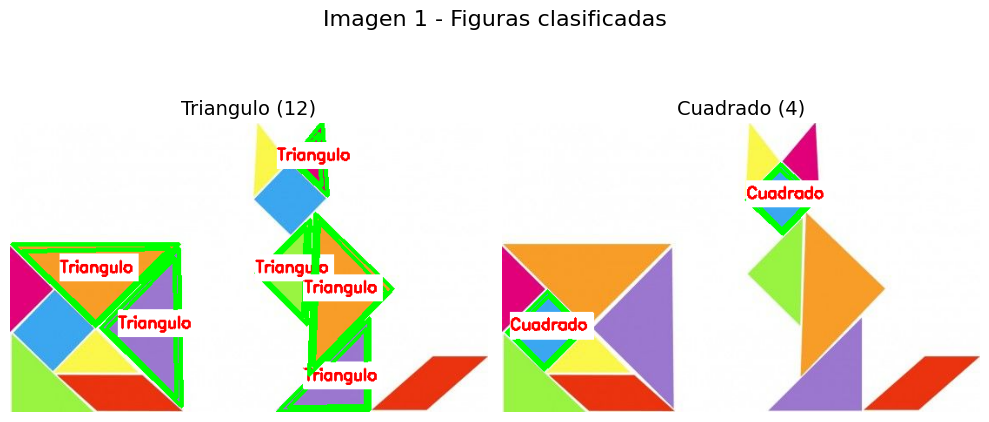

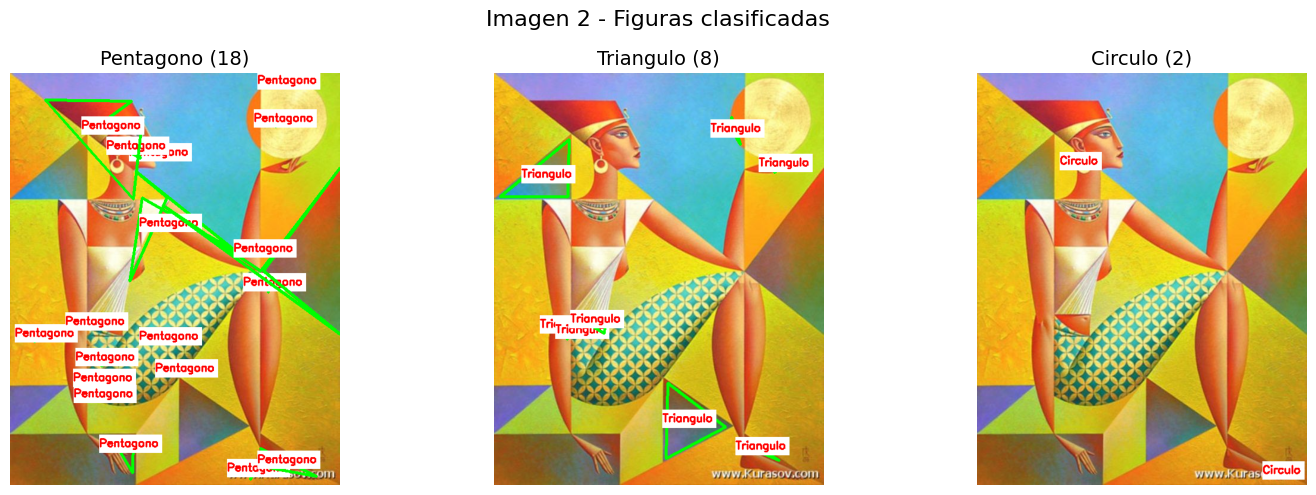

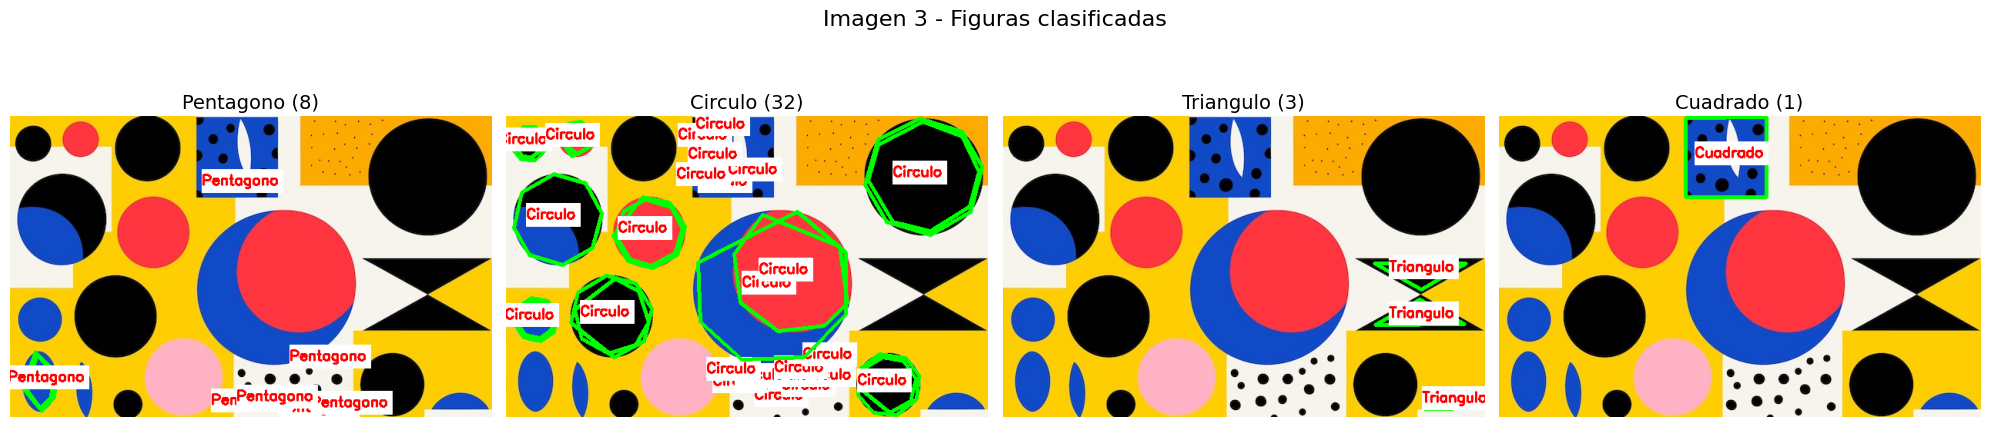

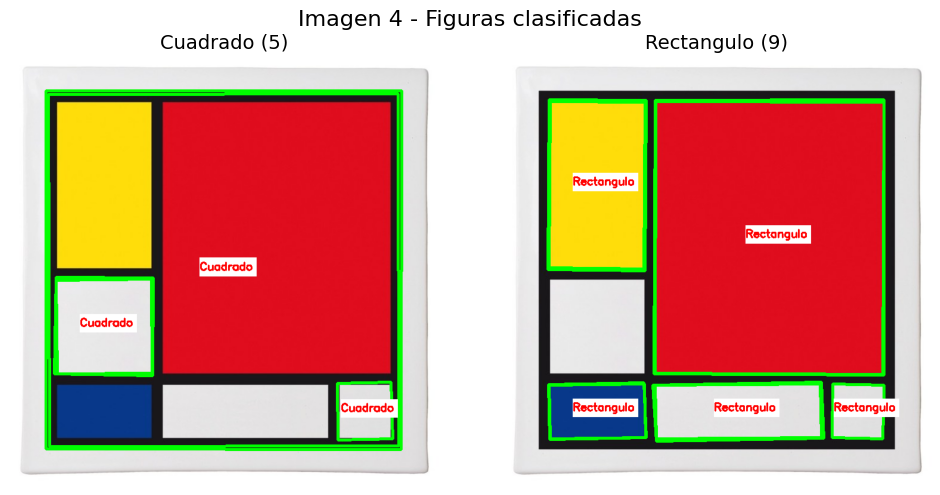

In [ ]:
import requests
import numpy as np
import matplotlib.pyplot as plt
import cv2

# URLs de imágenes
urls = [
    "https://i.pinimg.com/564x/12/81/7d/12817d843e6f71ac3fbbeafd711593ef.jpg",
    "https://i.pinimg.com/564x/1b/c8/06/1bc806be7192818e1aef2c0067d809d2.jpg",
   "https://img.freepik.com/vector-premium/obras-arte-coloridas-figuras-geometricas-elementos-graficos-audaces-composicion-plana_167718-1130.jpg",
    "https://www.rionegro.com.ar/wp-content/uploads/2024/01/cuadros-mondrian-arte-abstracto-20x20-decoracion-mondrian-11934-mla20052593222_022014-f.jpg?w=720"



]


#Mejoramos la detección de círculos y rectángulos:
#Verifica los ángulos internos usando productos escalares, no solo la relación ancho/alto.
#Clasifica también paralelogramos o trapecios si los ángulos no son cercanos a 90°.
def es_rectangulo_preciso(aprox, tolerancia_angulo=10):
    if len(aprox) != 4:
        return False

    def angulo(p1, p2, p3):
        v1 = p1 - p2
        v2 = p3 - p2
        ang = np.arccos(
            np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        )
        return np.degrees(ang)

    puntos = aprox.reshape(4, 2)
    for i in range(4):
        p1 = puntos[i]
        p2 = puntos[(i + 1) % 4]
        p3 = puntos[(i + 2) % 4]
        ang = angulo(p1, p2, p3)
        if abs(ang - 90) > tolerancia_angulo:
            return False

    return True


def clasificar_figura(contorno):
    perimetro = cv2.arcLength(contorno, True)
    aprox = cv2.approxPolyDP(contorno, 0.04 * perimetro, True)
    vertices = len(aprox)
    area = cv2.contourArea(contorno)

    if vertices == 3:
        return "Triangulo"

    elif vertices == 4:
        if es_rectangulo_preciso(aprox):
            x, y, w, h = cv2.boundingRect(aprox)
            aspect_ratio = w / float(h)
            return "Cuadrado" if 0.95 <= aspect_ratio <= 1.05 else "Rectangulo"
        else:
            return "Desconocida"

    elif vertices == 5:
        return "Pentagono"

    elif vertices > 5:
        if perimetro > 0:
            circularidad = 4 * np.pi * area / (perimetro ** 2)
            if circularidad > 0.80:
                return "Circulo"

    return "Desconocida"


# Procesar cada imagen
for index, url in enumerate(urls):
    try:
        response = requests.get(url)
        imagen = np.frombuffer(response.content, np.uint8)
        imagen_color = cv2.imdecode(imagen, cv2.IMREAD_COLOR)

        if imagen_color is None:
            continue

        # Preprocesamiento
        gris = cv2.cvtColor(imagen_color, cv2.COLOR_BGR2GRAY)
        suavizada = cv2.GaussianBlur(gris, (5, 5), 0)
        binaria = cv2.adaptiveThreshold(suavizada, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY_INV, 11, 2)

        # Detección de contornos
        # Los contornos se obtienen sobre la imagen binaria. Se consideran contornos externos e internos
        #a diferencia del cídgo usado en la codificación inicial, que sólo detectaba los externos.
        contornos, _ = cv2.findContours(binaria, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Clasificar figuras
        figuras_detectadas = []
        for contorno in contornos:
            area = cv2.contourArea(contorno)
            if area > 50:
                tipo = clasificar_figura(contorno)
                figuras_detectadas.append((contorno, tipo))

        # Agrupar por tipo, pero ignorar los desconocidos en la visualización
        tipos_presentes = {}
        for contorno, tipo in figuras_detectadas:
            if tipo == "Desconocida":
                continue  # Ignora figuras no clasificadas
            if tipo not in tipos_presentes:
                tipos_presentes[tipo] = []
            tipos_presentes[tipo].append(contorno)

        num_figuras = len(tipos_presentes)
        if num_figuras == 0:
            print(f"No se encontraron figuras reconocidas en la imagen {index + 1}.")
            continue

        fig, axs = plt.subplots(1, num_figuras, figsize=(5*num_figuras, 5))
        if num_figuras == 1:
            axs = [axs]

        for i, (tipo_figura, contornos_figura) in enumerate(tipos_presentes.items()):
            imagen_copia = imagen_color.copy()

            for contorno in contornos_figura:
                perimetro = cv2.arcLength(contorno, True)
                aprox = cv2.approxPolyDP(contorno, 0.04 * perimetro, True)
                M = cv2.moments(contorno)
                if M["m00"] != 0:
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    cv2.drawContours(imagen_copia, [aprox], -1, (0, 255, 0), 3)

                    (tw, th), baseline = cv2.getTextSize(tipo_figura, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
                    cv2.rectangle(imagen_copia, (cX - 40, cY - th - 6),
                                  (cX - 40 + tw + 4, cY + baseline + 4), (255, 255, 255), -1)
                    cv2.putText(imagen_copia, tipo_figura, (cX - 40, cY),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

            axs[i].imshow(cv2.cvtColor(imagen_copia, cv2.COLOR_BGR2RGB))
            axs[i].set_title(f"{tipo_figura} ({len(contornos_figura)})", fontsize=14)
            axs[i].axis('off')

        plt.suptitle(f"Imagen {index + 1} - Figuras clasificadas", fontsize=16)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error procesando la imagen {url}: {e}")

**INFORME:**

**Objetivo**

Detectar, clasificar y etiquetar figuras geométricas básicas (triángulos, rectángulos, cuadrados, círculos y pentágonos) a partir de imágenes descargadas desde internet, utilizando técnicas de visión por computadora con OpenCV.

**Metodología**
1. Adquisición de imágenes:
Se utilizó una lista de URLs para descargar automáticamente imágenes de arte geométrico. La descarga se realizó con requests y el decodificado con cv2.imdecode.

2. Preprocesamiento:
Cada imagen fue convertida a escala de grises y luego suavizada usando un filtro Gaussiano para eliminar ruido. Posteriormente se aplicó umbralización adaptativa inversa, ideal para imágenes con iluminación heterogénea.

3. Detección de contornos:
Se aplicó cv2.findContours sobre la imagen binaria, primero usando RETR_EXTERNAL para contornos externos y luego RETR_TREE para incluir internos, lo que permite detectar contornos jerárquicos, incluyendo figuras dentro de otras. Esto amplía las posibilidades de detección, especialmente útil en imágenes más complejas.

4. Clasificación de formas:

Se realizó un análisis basado en:

* Un primer intento de clasificación, que sólo se basa en la relación de aspecto (w/h) y en el número de vértices:
      *   Número de vértices (3 para triángulo, 4 para cuadrado o rectángulo, >5 para círculo).
      *   Relación de aspecto (ancho/alto) para diferenciar cuadrados de rectángulos.

* Se mejora la clasificación al agregar:
*   Verificación angular con coseno entre vectores para confirmar que una figura con 4 vértices tiene ángulos cercanos a 90° (rectángulo preciso).
*   Circularidad para detectar círculos reales:


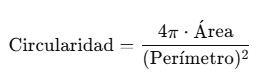

*Esto hace que el reconocimiento sea más preciso y confiable.


5. Visualización:
Se generó un grid de subplots mostrando:

*   Imagen original
*   Imagen binaria
*   Contornos
*   Clasificación (con etiquetas)
*   Perímetros

Además, en el código con mejoras, se agruparon figuras por tipo en visualizaciones separadas, para mejorar la presentación de los resultados.

**Conclusiones**

*   El sistema desarrollado logró detectar y clasificar correctamente figuras geométricas básicas y con la mejora de algunos métodos se llegó a un alto grado de precisión.

*   La incorporación de criterios geométricos adicionales (ángulos, circularidad) permitió reducir falsos positivos, en especial en figuras complejas como paralelogramos o elipses.

*   Las técnicas utilizadas son altamente efectivas para entornos controlados (fondo claro y figuras bien definidas), pero podrían requerir ajustes (como filtros morfológicos) ante fondos ruidosos o arte abstracto.

**Grupo:**

*   Alvarez Analia
*   Berraud Ana Lía
*   Leguizamón Paolo




